In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font = FontProperties(fname='../library/heiti.ttf', size=12)
import matplotlib.cm as cm
import skimage.transform
import argparse
#from scipy.misc import imresize
from imageio import imread
from PIL import Image
print("torch.version=", torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device=",device)

torch.version= 1.7.0+cu101
device= cuda:0


In [2]:
main_name1 = "flickr30kzh_5_cap_per_img_5_min_word_freq_seg_based"
main_name2 = "flickr30kzh_5_cap_per_img_5_min_word_freq_char_based"
main_name3 = "flickr8kzh_5_cap_per_img_5_min_word_freq_seg_based"
main_name4 = "flickr8kzh_5_cap_per_img_5_min_word_freq_char_based"

model1 = "../checkpoints/BEST_checkpoint_" + main_name1 + "_fine_tune.pth.tar"
model2 = "../checkpoints/BEST_checkpoint_" + main_name2 + "_fine_tune.pth.tar"
model3 = "../checkpoints/BEST_checkpoint_" + main_name3 + "_fine_tune.pth.tar"
model4 = "../checkpoints/BEST_checkpoint_" + main_name4 + "_fine_tune.pth.tar"

word_map1 ="../prepared_data/WORDMAP_" + main_name1 + ".json"
word_map2 ="../prepared_data/WORDMAP_" + main_name2 + ".json"
word_map3 ="../prepared_data/WORDMAP_" + main_name3 + ".json"
word_map4 ="../prepared_data/WORDMAP_" + main_name4 + ".json"



In [3]:
def read_image_and_resize(image_path):
    # Read image and process
    img = imread(image_path)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    #img = imresize(img, (256, 256))
    img = np.array(Image.fromarray(img).resize((256,256), Image.BICUBIC))
    
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)  # (3, 256, 256)
    return image

In [4]:
def caption_image_greedy_search(encoder, decoder, image_path, word_map):
    """
    Reads an image and captions it with beam search.
    
    :param encoder: encoder model
    :param decoder: decoder model
    :param image_path: path to image
    :param word_map: word map
    :param beam_size: number of sequences to consider at each decode-step
    :return: caption, weights for visualization
    """

    vocab_size = len(word_map)
    word_map_start = word_map['<start>']
    word_map_end = word_map['<end>']
    image = read_image_and_resize(image_path)

    # Encode
    image = image.unsqueeze(0)  # (1, 3, 256, 256)
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)
    enc_image_size = encoder_out.size(1)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # Generate
    seq, alphas = decode(decoder, encoder_out, encoder_dim, enc_image_size, word_map_start, word_map_end)
    return seq, alphas

In [5]:
def visualize_att(image_path, seq, alphas, rev_word_map, smooth=True):
    """
    Visualizes caption with weights at every word.

    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb

    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]
    fig = plt.figure(figsize=(20, 5))
    for t in range(len(words)):
        if t > 50:
            break
        
        plt.subplot(np.ceil(len(words) / 10.), 10, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12, fontproperties=font)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.detach().numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.detach().numpy(), [14 * 24, 14 * 24])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()

In [6]:
def decode(decoder, encoder_out, encoder_dim, enc_image_size, word_map_start, word_map_end):
    """Generate one sample"""
    pre_word = torch.Tensor([word_map_start]).long().to(device)
    top_scores = torch.zeros(1, 1).to(device)
    h, c = decoder.init_hidden_state(encoder_out)
    sampled_ids = [word_map_start]
    alphas = torch.ones(1, enc_image_size, enc_image_size).to(device)
    inputs = pre_word
    while True:
        embeddings = decoder.embedding(inputs)  # (1, embed_dim)
        awe, alpha = decoder.attention(encoder_out, h)  # (1, encoder_dim), (1, num_pixels)
        alpha = alpha.view(-1, enc_image_size, enc_image_size) # (1, enc_image_size, enc_image_size)
        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (1, encoder_dim)
        awe = gate * awe
        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))
        score = decoder.fc(h)  # (1, vocab_size)
        preds = F.log_softmax(score, dim=1)
        _, pred = preds.view(-1).topk(1)
        sampled_ids.append(pred.item())
        alphas=torch.cat((alphas, alpha), dim=0)
        if pred == word_map_end: break
        next_input = pred
        inputs = torch.Tensor([next_input]).long().to(device)
    return sampled_ids, alphas

In [7]:
def run():

    for x in [[model1, word_map1],[model2, word_map2],[model3, word_map3],[model4, word_map4]]:
        model, word_map = x
        # Load model
        checkpoint = torch.load(model, map_location=str(device))
        decoder = checkpoint['decoder']
        decoder = decoder.to(device)
        decoder.eval()
        encoder = checkpoint['encoder']
        encoder = encoder.to(device)
        encoder.eval()

        # Load word map (word2ix)
        with open(word_map, 'r') as j:
            word_map = json.load(j)
        rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

        # Encode, decode with attention and greedy search
        seq, alphas = caption_image_greedy_search(encoder, decoder, img, word_map)
        alphas = torch.FloatTensor(alphas.to("cpu"))
        decoded_seq = []
        for item in seq:
            decoded_seq.append(rev_word_map[item])
        print(decoded_seq)
        
        # Visualize caption and attention of best sequence
        visualize_att(img, seq, alphas, rev_word_map, smooth=False)

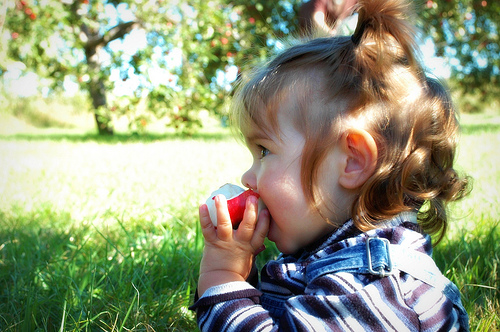

['<start>', '一个', '小', '女孩', '坐', '在', '草地', '上', '吃', '着', '一个', '苹果', '<end>']


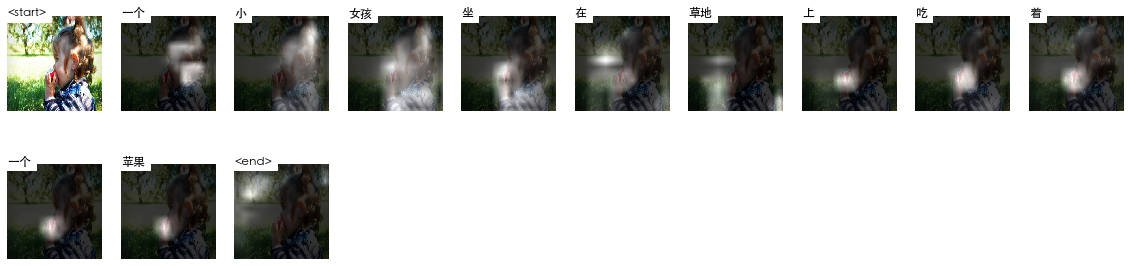

['<start>', '一', '个', '小', '女', '孩', '在', '一', '个', '蓝', '色', '的', '衬', '衫', '吃', '一', '个', '苹', '果', '<end>']


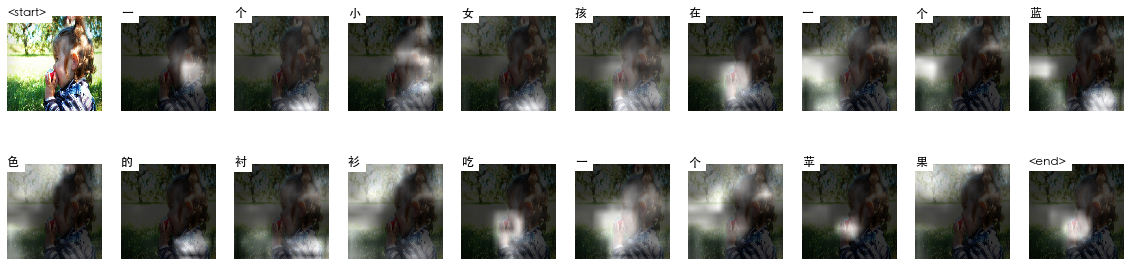

['<start>', '一个', '小', '男孩', '在', '草地', '上', '微笑', '着', '<end>']


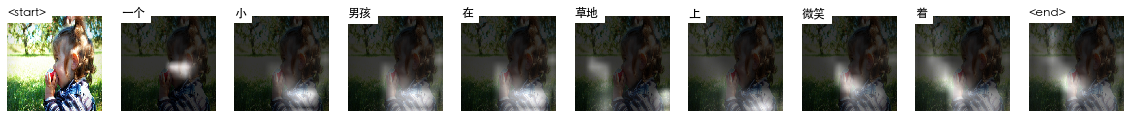

['<start>', '一', '个', '小', '女', '孩', '在', '一', '个', '绿', '色', '的', '衬', '衫', '上', '有', '一', '个', '金', '属', '框', '架', '<end>']


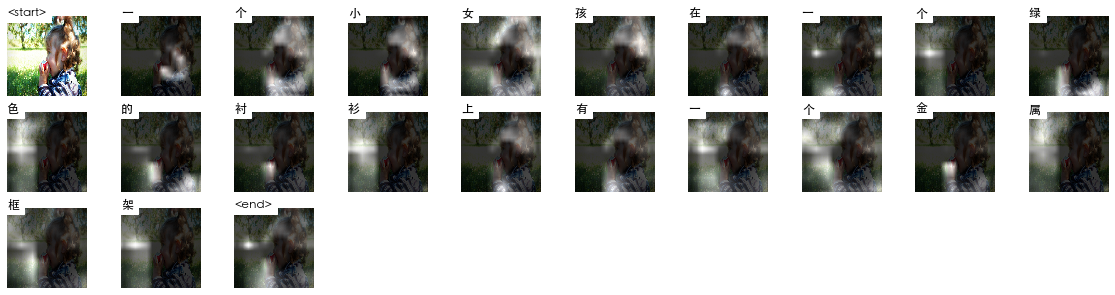

In [9]:
import os
import random
from IPython.display import Image as DisplayImage
directory = '../data/flickr30k_images/'
#directory = '../data/images/test/'
#directory = '../testimage/'
for filename in random.sample(os.listdir(directory), 1):
    if filename.endswith("jpg") == False: continue
    #img = "../data/flickr8k_images/"+str(line)[0:-2]+".jpg"
    img=directory+filename
    display(DisplayImage(img, width=150, height=150))
    run()